
# Connecting Two DNA Strands and Integration with Protein Data
This tutorial demonstrates how to identify and connect two separate DNA strands from a loaded structure, and integrate the connected DNA with protein components. This process is essential for creating comprehensive models for visualization and analysis.

## Steps Covered:
- Load and identify DNA strands in a structure containing proteins.
- Calculate and visualize control points for connecting DNA strands.
- Connect the DNA strands and integrate the result with the protein structure.
- Visualize and save the new combined structure.


## Loading the Structure and Identifying DNA Strands
Load a PDB file containing both DNA and protein components and identify DNA strands based on residue names.

In [1]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import nglview as nv
import mdna

In [2]:
# Load the structure
traj = md.load('./pdbs/8srp.pdb')
protein = traj.atom_slice(traj.top.select('protein'))
view = nv.show_mdtraj(traj)

view

/Users/thor/miniforge3/envs/mdna/lib/python3.12/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


NGLWidget()

## Identifying DNA Chains
Extract the indices of DNA chains based on common residue names for nucleotides.

In [3]:
DNA_residue_names = ['DG','DC','DT','DA']
DNA_chainids = []
for chain in traj.top.chains:
    for res in chain._residues:
         if str(res.name) in DNA_residue_names:
            DNA_chainids.append(res.chain.index)
DNA_chainids = np.unique(DNA_chainids)
DNA_chainids = np.array([DNA_chainids[i:i + 2] for i in range(0, len(DNA_chainids), 2)])

## Connecting DNA Strands
Load the DNA strands, calculate control points for connection, and visualize the initial and connected states.

(-10.94905859894223,
 44.446358746952484,
 -10.83135897583432,
 44.564058370060394,
 5.5965357522169725,
 47.14309876163801)

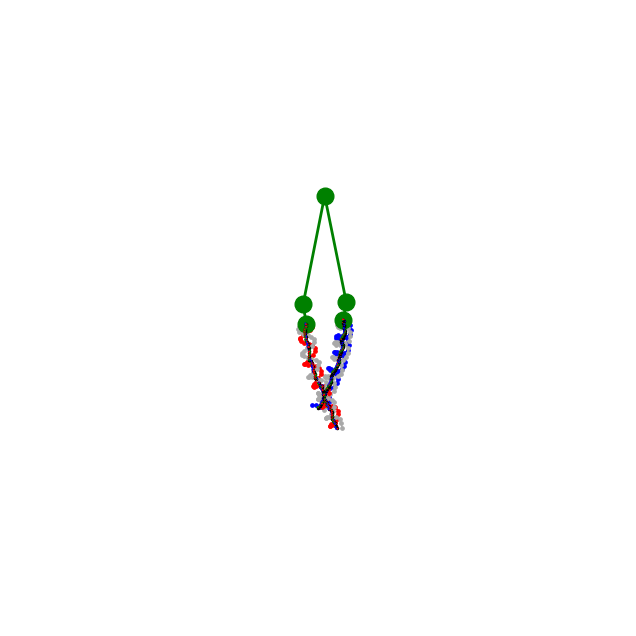

In [4]:
dna_a = mdna.load(traj=traj, chainids=DNA_chainids[0])
dna_b = mdna.load(traj=traj, chainids=DNA_chainids[1])

# Get frames to calculate control points
frames_a = dna_a.get_frames()
frames_b = dna_b.get_frames()
start = np.squeeze(frames_a[-1])[0]
end = np.squeeze(frames_b[0])[0]

# Calculate incremental positions for smoother curves
start_increment = start + np.array([0.5, 0, 3])
end_increment = end + np.array([-0.5, 0, 3])
center_of_mass = (start + end) / 2
center_of_mass += np.array([0, 0, 1]) * 20
control_points = np.array([start, start_increment, center_of_mass, end_increment, end])

# Draw initial strands and control points
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
dna_a.draw(ax=ax, triads=True, color_lead='blue')
dna_b.draw(ax=ax, triads=True, color_lead='red')
ax.plot(control_points[:,0], control_points[:,1], control_points[:,2], marker='o', color='g', linestyle='-', linewidth=2, markersize=12)
ax.axis('equal')


Now the control point shave been defined we can make the loop.

In [5]:
# Connect the strands
dna_c = mdna.connect(dna_a, dna_b, control_points=control_points)
dna_c.draw(ax=ax)

Optimal BP: 26, Twist Difference per BP: 0.176 degrees
Optimal number of base pairs: 26
Random sequence: GAGAGTTGTTAGGAGTCAAGGAGCAGATATTTTCCCGCCAAAACCGTTCTTACATCCTCTGTGTCTGACAACTACGAGCATGGTGGGTATCCGGCACCGCGGGGGTGTTGGCTCCCATAGA 

Minimize the DNA structure:
simple equilibration = False 
equilibrate writhe = False 
excluded volume radius = 0.0 
temperature = 300
Circular: False


## Visualization and Saving the Connected Structure
Combine the connected DNA with the protein structure and visualize the complete assembly.

In [6]:
# Combine DNA and protein trajectories
dna_traj = dna_c.get_traj()
connected_traj = protein.stack(dna_traj)
view = nv.show_mdtraj(connected_traj)
view



NGLWidget()

In [7]:
# Save the combined structure
connected_traj.save('./pdbs/8srp_connected.pdb')